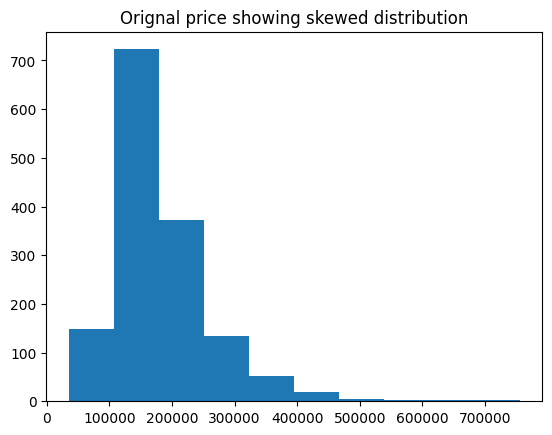

Text(0.5, 1.0, 'Price logged showing normal distribution')

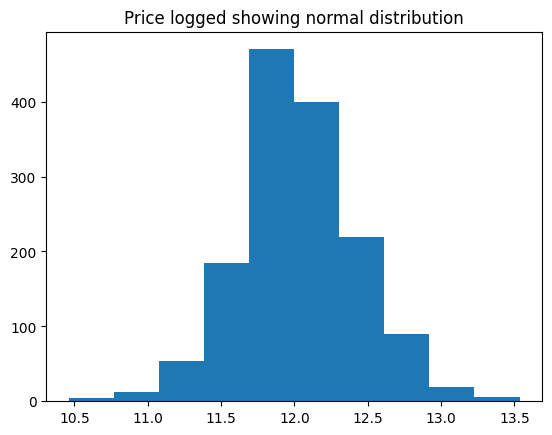

In [133]:
import matplotlib.pyplot as plt
import numpy as np

price = list(data.SalePrice)
plt.hist(price)
plt.title('Orignal price showing skewed distribution')
plt.show()
plt.hist(np.log(price))
plt.title('Price logged showing normal distribution')

In [ ]:
from sklearn.linear_model import LassoCV
import numpy as np
import pymc as pm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Lasso regression minimizes the residual sum of squares (RSS), which assumes the errors (residuals) follow a Gaussian (normal) distribution. This assumption often holds well when:
# The target variable itself (e.g., housing prices) is normally distributed.
# Or, the target has been transformed to approximate normality (e.g., log transformation).
# In your case, you log-transformed the prices (PriceLogged) to make the distribution more normal. This transformation aligns well with Lasso’s assumptions, as it reduces skewness and stabilizes variance, leading to:
# Better predictions.
# A model where the coefficients more accurately reflect the relationships between features and the target.

def preprocess_data(X:pd.DataFrame):
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

    # print("Numeric Columns:", numeric_cols)
    # print("Categorical Columns:", categorical_cols)

    # Define preprocessing pipelines
    numeric_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

    # Combine pipelines using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_pipeline, numeric_cols),
            ('cat', categorical_pipeline, categorical_cols)
        ]
    )

    # Fit and transform the data
    X_transformed = preprocessor.fit_transform(X)

    # Get feature names
    categorical_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
    processed_features = list(numeric_cols) + list(categorical_features)

    # Convert transformed data to a DataFrame
    X_df = pd.DataFrame(X_transformed, columns=processed_features)
    return X_df


# find the best features using Lasso
def find_best_features_with_lasso(X_df:pd.DataFrame, y_df:pd.DataFrame):
    # Train Lasso model with cross-validation
    lasso = LassoCV(cv=5, random_state=42).fit(X_df, y_df)

    # Get feature importance
    lasso_coefficients = pd.Series(lasso.coef_, index=X_df.columns)
    important_features_to_use = lasso_coefficients[lasso_coefficients != 0]

    # print("Lasso Selected Features:\n", important_features_to_use)

    important_features = list(important_features_to_use.index)
    return important_features


# get the posterior probability
# get the priors: coefficients and intercept (both normal distribution with both having mu=0 and sigma=10)
# make the likelihood (normal (mu, sigma)):
#       mu = use the priors, combined with the features to make linear functions for the mu paramter of the likelihood distribution
#       sigma = HalfNormal???
# use mcmc to calculate the posterior distribution

# coefficients ───┐
#                 │   ---> mu = dot(X, coefficients) + intercept
# intercept   ───┘               │
#                                 ↓
# sigma ──────────────────────────┼──> price_obs ~ Normal(mu, sigma)
#                                 │
#                            Observed Data: y_train

def get_bayesian_posterior_distribution(X_train:pd.DataFrame, y_train:pd.DataFrame):
    # Define the Bayesian model
    with pm.Model() as housing_model:
        # Priors for coefficients
        # coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X_train.shape[1])
        coefficients = pm.Normal('coefficients', mu=0, sigma=10, shape=X_train.shape[1])
        intercept = pm.Normal('Intercept', mu=0, sigma=10)

        # Define the linear model
        mu = pm.math.dot(X_train.values, coefficients) + intercept

        # Likelihood function
        sigma = pm.HalfNormal('sigma', sigma=10)   
        #"Given the parameters μ and σ, how likely are the observed values y train to occur?"  
        price_obs = pm.Normal('Price', mu=mu, sigma=sigma, observed=y_train.values) # The observed=y_train.values part in price_obs tells PyMC: These are the actual observed values for the target variable.

        # Sampling using MCMC
        # Identifies all the stochastic variables (like coefficients, intercept, sigma) and the likelihood (price_obs) in the model.
        # Initializes the posterior sampling process using algorithms like NUTS (No-U-Turn Sampler, a variant of Hamiltonian Monte Carlo).
        # Iteratively samples from the posterior distributions of the parameters, ensuring that the samples are consistent with the prior distributions and the likelihood of the observed data.        
        
        # How Does PyMC Know What to Sample?
        # Priors: Any random variable (e.g., pm.Normal, pm.HalfNormal) defined inside the pm.Model() context is recognized as a prior.
        # Likelihood: Any variable defined with observed=... is treated as the likelihood and connects the observed data to the priors.
        # Relationships: Deterministic relationships (like mu = dot(...) + intercept) are automatically included in the model graph.        
        trace = pm.sample(1000, tune=1000, random_seed=42, cores=1)



    # Summarize posterior distributions
    summary = pm.summary(trace)
    return summary, trace


In [126]:
# Load the dataset
data = pd.read_csv('data/train.csv')
data['PriceLogged'] = list(np.log(np.array(list(data.SalePrice)))) # log the price so it has a normal distribution

# Separate features and target
# Ensure target is separated correctly
X = data.drop(columns=['SalePrice', 'PriceLogged'], errors='ignore')  # Drop target columns
y = data['PriceLogged']  # Use log-transformed price as target

# preprocess the data
X_df = preprocess_data(X=X)

# filter out the column which are not considered important
important_features = find_best_features_with_lasso(X_df=X_df, y_df=y)
X_df = X_df[important_features]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

summary, trace = get_bayesian_posterior_distribution(X_train=X_train, y_train=y_train)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [coefficients, Intercept, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 28 seconds.


In [120]:
import arviz as az
import numpy as np

# Get posterior summaries for coefficients
posterior_summary = az.summary(trace, var_names=["coefficients"])
posterior_summary

# get the coefficients which are greater than 0
not_0_coeffs = np.where(np.array(list(posterior_summary['mean'])) > 0)[0]
important_features = [list(X_train.columns)[i] for i in not_0_coeffs]

# add the feature names to the df
best_features_coeffs = posterior_summary.iloc[not_0_coeffs]
best_features_coeffs['feature_names'] = important_features

# sort the features on ascending order of importance
best_features_coeffs = best_features_coeffs.sort_values(by='mean', ascending=False)
best_features_coeffs.head(20)

/var/folders/yn/bkfdzjnd0y78gcz28ddlslhr0000gn/T/ipykernel_28999/255830094.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_features_coeffs['feature_names'] = important_features


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,feature_names
coefficients[47],0.192,0.032,0.133,0.253,0.001,0.000,2949.0,1320.0,1.00,Neighborhood_StoneBr
coefficients[39],0.139,0.023,0.097,0.182,0.000,0.000,2801.0,1726.0,1.01,Neighborhood_Crawfor
coefficients[44],0.123,0.022,0.087,0.168,0.000,0.000,2956.0,1649.0,1.00,Neighborhood_NridgHt
coefficients[53],0.113,0.022,0.073,0.154,0.000,0.000,3349.0,1465.0,1.00,Exterior1st_BrkFace
coefficients[12],0.101,0.012,0.078,0.124,0.000,0.000,1530.0,1476.0,1.00,GrLivArea
coefficients[49],0.100,0.035,0.031,0.160,0.001,0.001,1758.0,1272.0,1.00,BldgType_2fmCon
coefficients[43],0.083,0.024,0.040,0.130,0.000,0.000,3250.0,1534.0,1.00,Neighborhood_NoRidge
coefficients[46],0.078,0.035,0.011,0.140,0.001,0.001,2303.0,1590.0,1.00,Neighborhood_Somerst
coefficients[4],0.076,0.007,0.062,0.090,0.000,0.000,2122.0,1302.0,1.00,OverallQual
coefficients[70],0.076,0.019,0.039,0.110,0.000,0.000,2870.0,1487.0,1.00,CentralAir_Y


In [121]:
import numpy as np

# Step 1: Convert X_test to NumPy for matrix operations
X_test_np = X_test.values  # Shape: (n_test, n_features)

# Step 2: Extract posterior samples for coefficients and intercept
coefficients_samples = trace.posterior['coefficients'].values  # Shape: (chains, draws, n_features)
intercept_samples = trace.posterior['Intercept'].values  # Shape: (chains, draws)

# Flatten the samples (combine chains and draws)
coefficients_samples = coefficients_samples.reshape(-1, coefficients_samples.shape[-1])  # Shape: (n_samples, n_features)
intercept_samples = intercept_samples.flatten()  # Shape: (n_samples,)

# Debugging Shapes
print("Shape of coefficients_samples:", coefficients_samples.shape)  # (n_samples, n_features)
print("Shape of intercept_samples:", intercept_samples.shape)  # (n_samples,)
print("Shape of X_test_np:", X_test_np.shape)  # (n_test, n_features)

# Step 3: Compute predictions
# Dot product of posterior samples with X_test, plus intercept
predictions = np.dot(coefficients_samples, X_test_np.T) + intercept_samples[:, None]  # Shape: (n_samples, n_test)

# Step 4: Calculate mean and credible intervals for predictions
predicted_mean = predictions.mean(axis=0)  # Mean prediction for each test point
credible_intervals = np.percentile(predictions, [2.5, 97.5], axis=0)  # 95% credible intervals

# Step 5: Display predictions
actual_values = list(y_test)
for i, (mean, ci) in enumerate(zip(predicted_mean, credible_intervals.T)):
    print(f"Test Row {i}: Predicted Mean = {mean:.2f}, 95% CI = ({ci[0]:.2f}, {ci[1]:.2f})")

    print('\tactual_value --> ', actual_values[i])

Shape of coefficients_samples: (2000, 84)
Shape of intercept_samples: (2000,)
Shape of X_test_np: (292, 84)
Test Row 0: Predicted Mean = 11.95, 95% CI = (11.89, 12.00)
	actual_value -->  11.947949375319936
Test Row 1: Predicted Mean = 12.67, 95% CI = (12.61, 12.73)
	actual_value -->  12.691580461311874
Test Row 2: Predicted Mean = 11.55, 95% CI = (11.49, 11.61)
	actual_value -->  11.652687407345388
Test Row 3: Predicted Mean = 11.97, 95% CI = (11.91, 12.04)
	actual_value -->  11.976659481202368
Test Row 4: Predicted Mean = 12.60, 95% CI = (12.55, 12.66)
	actual_value -->  12.661913960963405
Test Row 5: Predicted Mean = 11.29, 95% CI = (11.20, 11.38)
	actual_value -->  11.231887935237117
Test Row 6: Predicted Mean = 12.51, 95% CI = (12.43, 12.59)
	actual_value -->  12.649154617209645
Test Row 7: Predicted Mean = 11.84, 95% CI = (11.78, 11.91)
	actual_value -->  11.891361900690473
Test Row 8: Predicted Mean = 11.20, 95% CI = (11.11, 11.29)
	actual_value -->  11.344506813345266
Test Row 9

In [122]:
rss = np.sum(np.square(np.round(np.exp(actual_values)) - np.round(np.exp(predicted_mean))))

mse = rss / len(y_test)
print(f"Mean Squared Error (MSE): {mse:.2f}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Squared Error (MSE): 609979125.20
Root Mean Squared Error (RMSE): 24697.76


In [ ]:
# Mean Squared Error (MSE): 609697891.18
# Root Mean Squared Error (RMSE): 24692.06

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (86) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'coefficients\n0'}>,
        <Axes: title={'center': 'coefficients\n1'}>,
        <Axes: title={'center': 'coefficients\n2'}>,
        <Axes: title={'center': 'coefficients\n3'}>],
       [<Axes: title={'center': 'coefficients\n4'}>,
        <Axes: title={'center': 'coefficients\n5'}>,
        <Axes: title={'center': 'coefficients\n6'}>,
        <Axes: title={'center': 'coefficients\n7'}>],
       [<Axes: title={'center': 'coefficients\n8'}>,
        <Axes: title={'center': 'coefficients\n9'}>,
        <Axes: title={'center': 'coefficients\n10'}>,
        <Axes: title={'center': 'coefficients\n11'}>],
       [<Axes: title={'center': 'coefficients\n12'}>,
        <Axes: title={'center': 'coefficients\n13'}>,
        <Axes: title={'center': 'coefficients\n14'}>,
        <Axes: title={'center': 'coefficients\n15'}>],
       [<Axes: title={'center': 'coefficients\n16'}>,
        <Axes: title={'center': 'coefficients\n17'}>,
        <Axes: title={'center': 'c

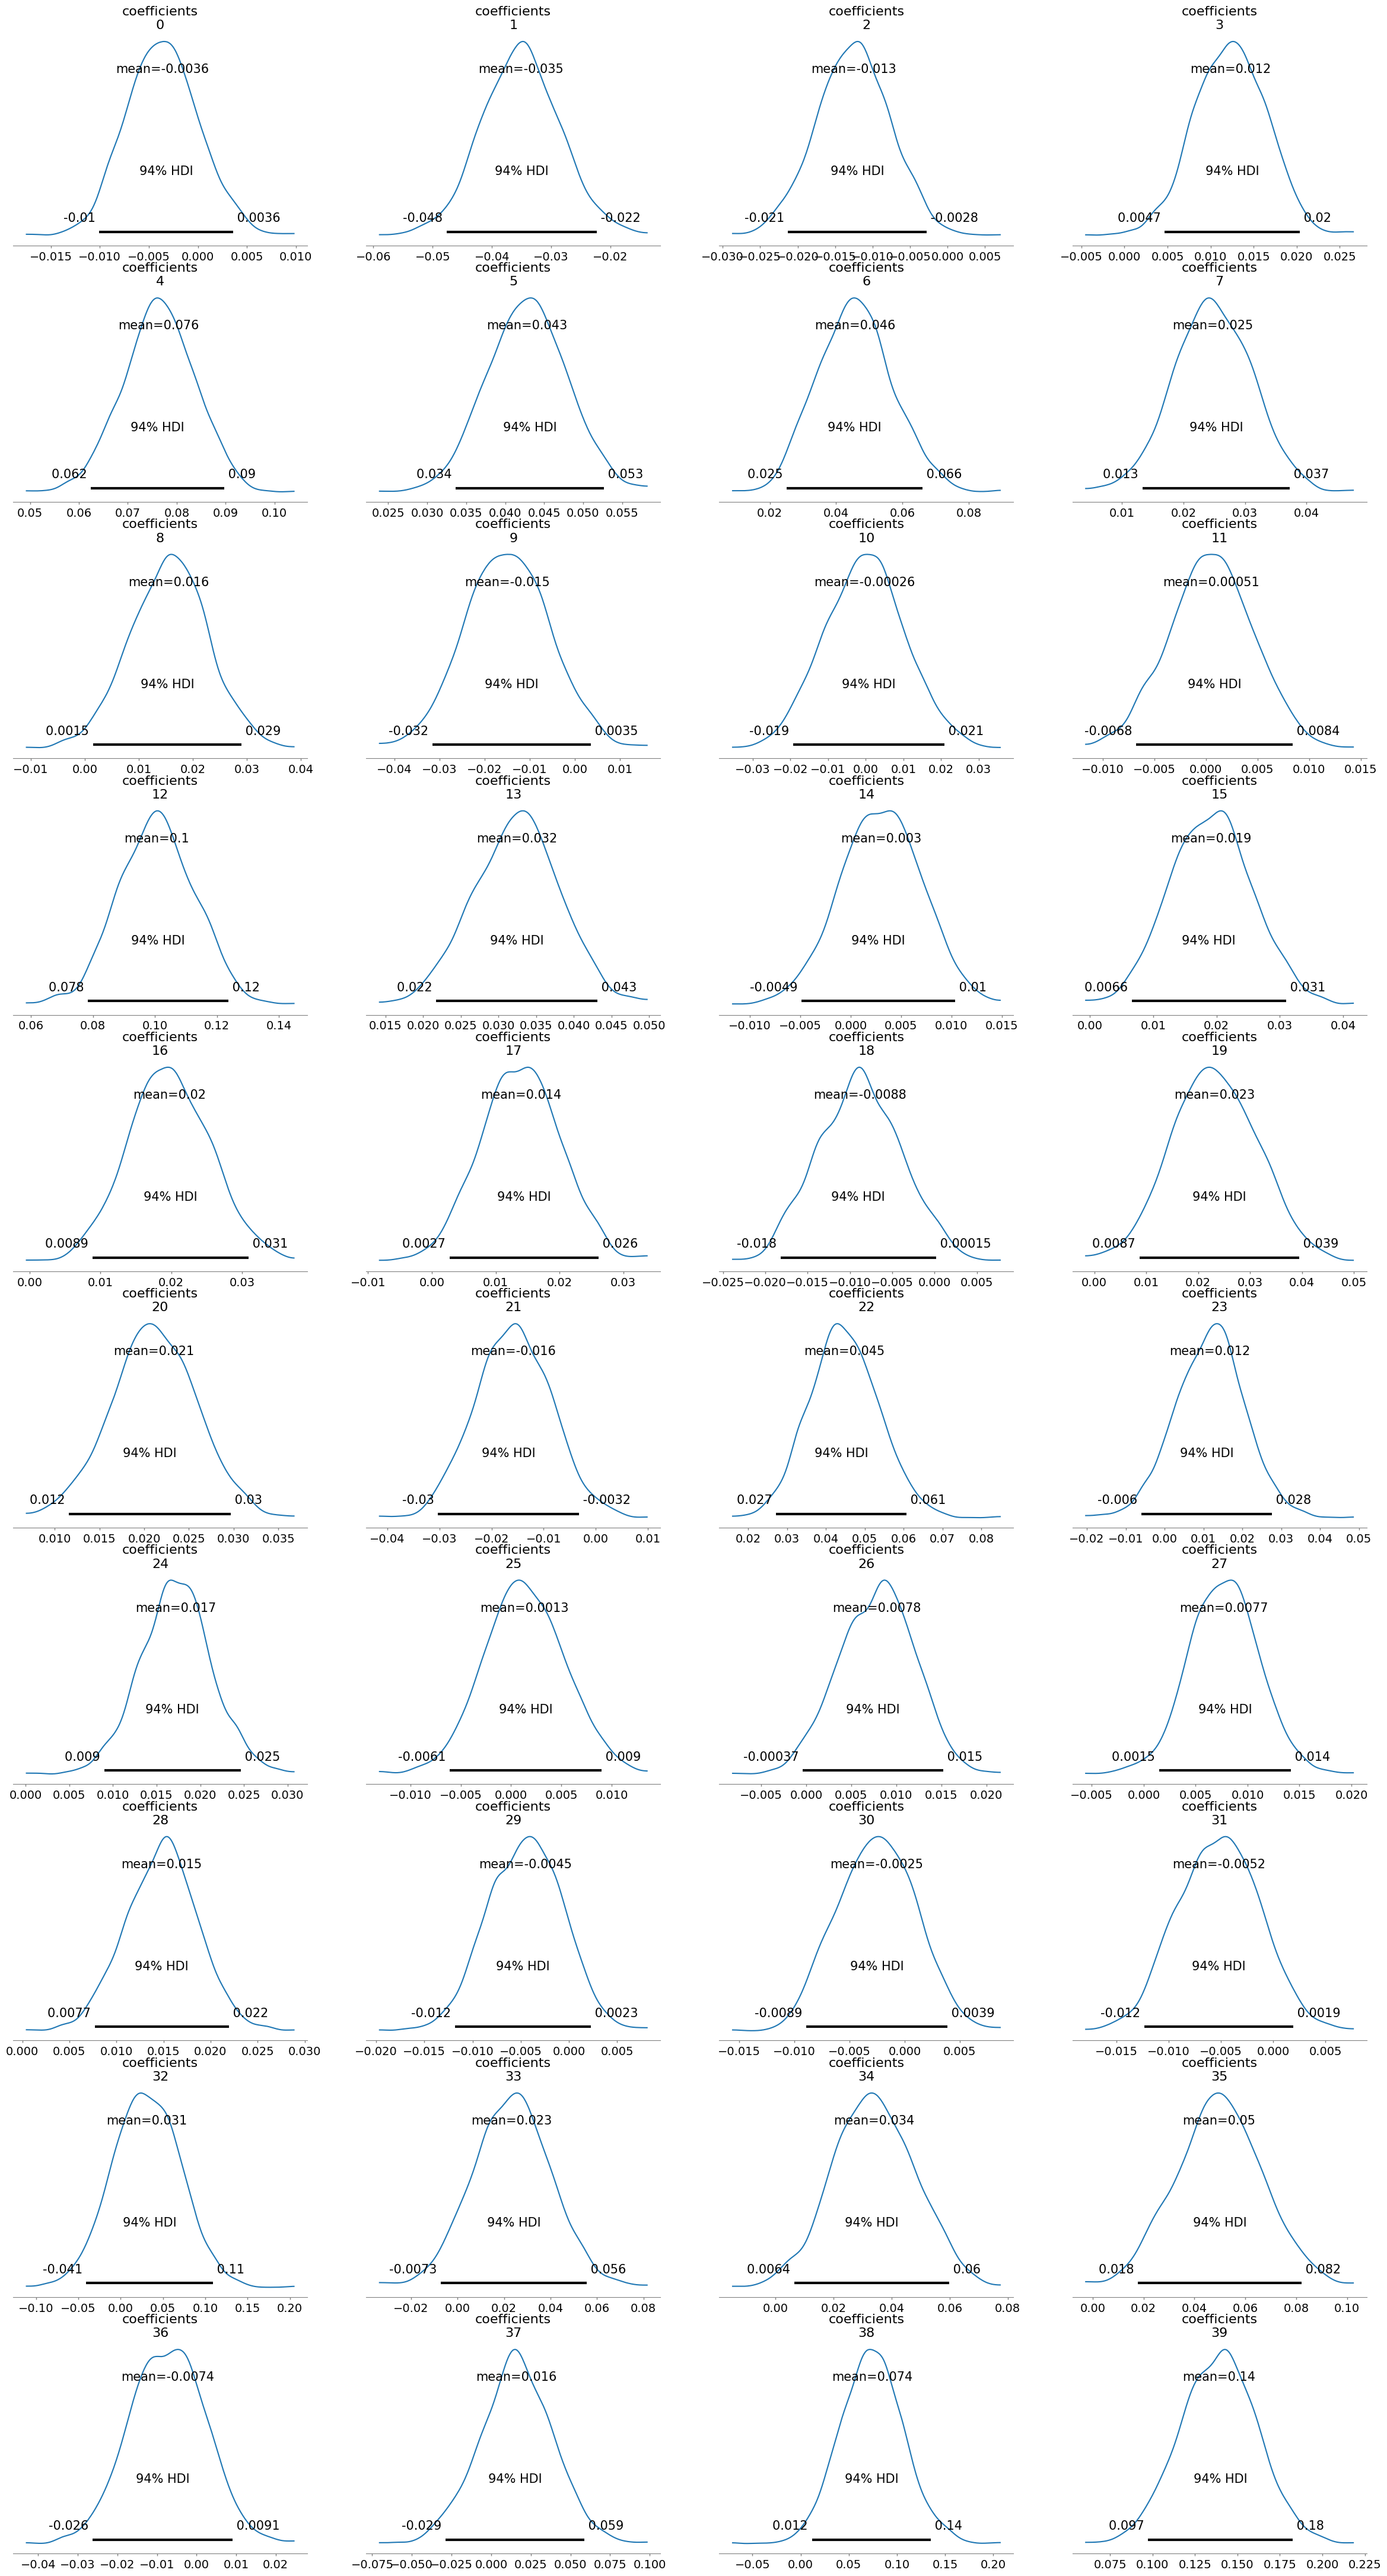

In [123]:
import arviz as az
az.plot_posterior(trace)


In [50]:
print(trace.posterior['coefficients'].shape[-1])


246


## Why use normal distribution for the priors:
Rationale: Normal priors are used here because they encode the belief that the parameter values are most likely to cluster around a central value (e.g., 0) but with some spread (controlled by the standard deviation, sigma).
- #### Why It's Relevant:
        - Most effects in real-world data tend to cluster around a central value (e.g., the effect of neighborhood or room size). The Normal distribution is flexible, allowing you to encode both uncertainty (using large sigma) and prior knowledge (using a specific mean, mu).

## Report section for explaining get_bayesian_posterior_distribution
The function get_bayesian_posterior_distribution(X_train: pd.DataFrame, y_train: pd.DataFrame) constructs and samples from a Bayesian linear regression model to estimate the posterior distributions of the model parameters. Specifically, it assumes that the target variable 
𝑦
train
y 
train
​
  follows a Normal distribution with a mean 
𝜇
μ, which is defined as a linear combination of the input features 
𝑋
train
X 
train
​
  and their corresponding weights (coefficients), plus an intercept term. Priors are placed on the model parameters: the coefficients and intercept are assigned weakly informative Normal distributions with mean 0 and standard deviation 10, while the residual standard deviation 
𝜎
σ is given a Half-Normal prior to enforce positivity. The likelihood function incorporates the observed target values to evaluate the probability of seeing the data given the current parameter estimates. Using Markov Chain Monte Carlo (MCMC) sampling, the function iteratively samples from the posterior distributions of the coefficients, intercept, and residual standard deviation. The resulting posterior summaries provide probabilistic estimates of the parameter values, including their means, standard deviations, and credible intervals, which quantify both the magnitude of the feature weights and the associated uncertainty.



#### Understanding: trace = pm.sample(1000, tune=1000, random_seed=42, cores=1)
The statement trace = pm.sample(1000, tune=1000, random_seed=42, cores=1) performs posterior sampling for the Bayesian model defined within the pm.Model() context. PyMC automatically identifies priors and the likelihood from the model components. Variables defined without the observed argument, such as the coefficients, intercept, and the residual standard deviation sigma, are treated as priors, representing prior beliefs about the model parameters. The likelihood, which includes the observed argument, connects the observed target data 
𝑦
train
y 
train
​
  to the model predictions (
𝜇
μ and 
𝜎
σ), evaluating how probable the data is given the current parameter values. During sampling, PyMC combines the priors and likelihood using Bayes’ theorem and employs algorithms like the No-U-Turn Sampler (NUTS) to efficiently explore the parameter space. The resulting samples, stored in trace, represent the posterior distributions of the model parameters, reflecting updated beliefs given the observed data.




### Model Assumptions and Justifications
The Bayesian regression model is designed to estimate housing prices based on a linear relationship between the input features and the target variable. Below, we provide detailed justifications for the choice of priors, the likelihood function, and the overall model structure, including why certain alternatives, such as uniform priors, were not used.

The priors for the coefficients and the intercept are modeled using Normal distributions with a mean of 0 and a standard deviation of 10. This choice reflects the prior belief that, before observing any data, the effects of the predictors (coefficients) and the baseline value (intercept) are centered around zero with moderate uncertainty. The mean of 0 assumes that the predictors initially have no significant influence on the target variable, while the standard deviation of 10 allows sufficient flexibility for large effects if the data supports it. This diffuse but weakly informative prior avoids imposing overly strong assumptions on the model.

We do not use uniform priors because they imply equal probability for all parameter values within a range, which can unintentionally result in overly large or unrealistic coefficients when the data is sparse or noisy. Uniform priors also lack regularization, which can lead to instability during sampling, particularly for high-dimensional models with many features. Normal priors, by contrast, provide a smoother and more realistic assumption about parameter behavior while incorporating flexibility for the observed data to guide the posterior estimates.

The linear model for the mean is defined as:
mu = dot(X_train, coefficients) + intercept

Here, the predictors in the training data are multiplied by their respective coefficients and combined with the intercept to compute the mean response. This formulation aligns with the assumption of a linear relationship between the features and the target variable, a common and interpretable approach in regression modeling. It allows us to quantify and interpret the contribution of each predictor directly.

The prior for the residual standard deviation, sigma, is modeled using a Half-Normal distribution with a standard deviation of 10. The Half-Normal prior is appropriate because sigma represents the standard deviation of the residuals and cannot be negative. This prior assumes that smaller values of sigma are more likely but allows for larger values when supported by the data. Alternatives such as uniform priors were avoided because they provide no constraint on the residual variability and could lead to instability during sampling. The Half-Normal prior balances simplicity and flexibility while remaining consistent with the non-negativity of sigma.

The likelihood function uses a Normal distribution to model the observed target values:
price_obs = Normal('Price', mu=mu, sigma=sigma, observed=y_train)

The Normal likelihood assumes that the observed log-transformed prices are distributed around the predicted mean with residual variability described by sigma. This choice is justified because the log transformation applied to the prices ensures approximate normality of the response variable, which aligns with the Gaussian assumption of the likelihood. Using a Normal distribution simplifies the computations and provides a natural connection to linear regression. Alternatives like the Gamma or Student-t distribution could be considered for skewed or heavy-tailed data, but the log transformation sufficiently addresses these issues in this case.

To estimate the model parameters, the No-U-Turn Sampler (NUTS), a variant of Markov Chain Monte Carlo (MCMC), is used. PyMC automatically identifies all stochastic variables, including the priors for coefficients, intercept, and sigma, and incorporates them into the sampling process. The likelihood function ensures that the observed data informs the posterior distributions of these parameters, balancing prior beliefs with evidence from the data.

In summary, the priors for the coefficients, intercept, and sigma are chosen to provide weakly informative yet realistic assumptions about the parameters. Normal priors avoid the instability of uniform priors while allowing the observed data to guide the posterior estimates. The linear model structure and the Normal likelihood are well-suited to the log-transformed response variable, ensuring computational stability and interpretability of the results.